# **4. Frequency Domain**

In [1]:
from configs.config import BASE_PATH
from matplotlib import pyplot as plt
import imageio
import numpy as np
import cv2
import os

path = os.path.join(BASE_PATH,"data","image",'opencv_image3.jpg')
img_gray = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = cv2.imread(path,cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## **0. Spatial Domain vs. Frequency Domain**

* Spatial Domain:
  
  * 이미지의 픽셀 값에 직접적으로 작용한다.
  
  * 필터링, 변환 등은 이미지의 픽셀을 직접 수정하여 처리한다.

  * Convolution을 통해서 다수의 연산을 진행한다.

<br>

* Frequency Domain:
  
  * 이미지의 주파수 성분을 분석하여 처리한다.
  
  * 푸리에 변환을 통해 주파수 영역으로 변환된 후 필터링을 적용헌더,
  
  * 필터는 주파수 성분의 곱으로 처리되며, 이를 다시 Spatial Domain으로 변환하여 결과를 얻는다.

<br>

* Spatail Domain에서의 컨볼루션  =  Frequency Domain에서의 곱셈.
  
* 두 도메인 간 변환은 푸리에 변환과 역푸리에 변환을 사용한다.

* Spatail Domain에서 연산은 $O(HWK^{2})$이다.
  * 픽셀 수 $HW$에 필터 사이즈 $K^{2}$에 채널까지 여러 개면 연산이 더 늘어난다.
  
* Frequency Domain에서 연산은 $O(HW*log(HW))$이다.

* 연산의 효율성을 위해서 Frequency에서 연산을 다루는 것이지만, 변환 과정이 있기 때문에 종합적으로 고려해야한다.

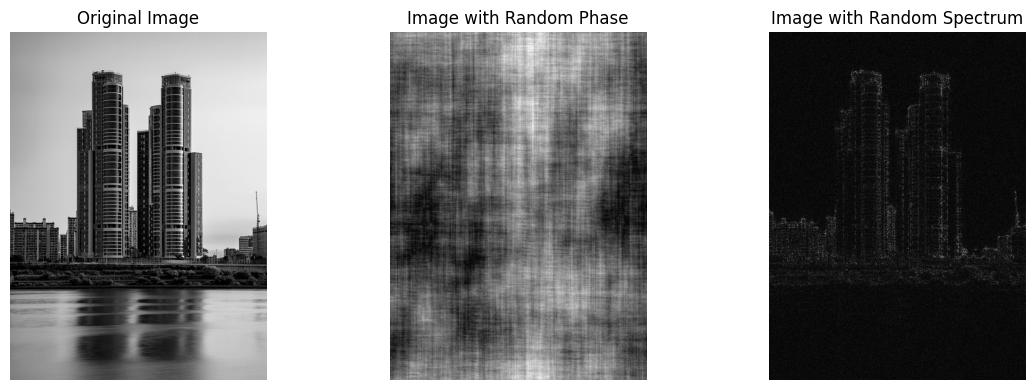

In [2]:
def FFT(img):
    img_freq = np.fft.fft2(img)
    img_freq_shift = np.fft.fftshift(img_freq)
    magnitude = 20 * np.log(np.abs(img_freq_shift) + 1)
    return img_freq_shift, magnitude

def IFFT(img_freq_shift):
    img_freq = np.fft.ifftshift(img_freq_shift)
    img = np.fft.ifft2(img_freq)
    img = np.abs(img)
    return img

def frequency_component(img):
    img_freq_shift,_ = FFT(img)
    magnitude = np.abs(img_freq_shift)
    phase = np.angle(img_freq_shift)
    return magnitude, phase

def magnitude_dmg(magnitude, phase):
    magnitude_modified = np.random.rand(*magnitude.shape) * np.max(magnitude)
    fshift_modified = magnitude_modified * np.exp(1j * phase)
    img_reconstructed = IFFT(fshift_modified)
    return img_reconstructed

def phase_dmg(magnitude, phase):
    phase_modified = np.random.rand(*phase.shape) * 2 * np.pi
    fshift_modified = magnitude * np.exp(1j * phase_modified)
    img_reconstructed = IFFT(fshift_modified)
    return img_reconstructed

magnitude, phase = frequency_component(img_gray)
img_magnitude_dmg = magnitude_dmg(magnitude, phase)
img_phase_dmg = phase_dmg(magnitude, phase)

fig,ax = plt.subplots(1,3,figsize=(12,4))

images = {
    'Original Image': img_gray,
    'Image with Random Phase': img_phase_dmg,
    'Image with Random Spectrum': img_magnitude_dmg
}


for i, (title, image) in enumerate(images.items()):
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(title)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

* Frequency Domain에서는 Magnitude보다 Phase에 중요한 정보(형태)를 담겨있다.

* fft2는 fft1을 x,y에서 두 번 진행한다.
    * 2D 변환보다 1D 변환 두 번이 연산량이 더 적다.

## **1. LPF, HPF**

* FFT 변환 이후 주파수 영역에서 고주파대, 저주파대 영역을 직접 0으로 만든 후 역변환을 해준다.

* Band Pass 자체가 특정 boundary를 기반으로 통과시키기 때문에 부드러운 형태의 결과는 아니다.

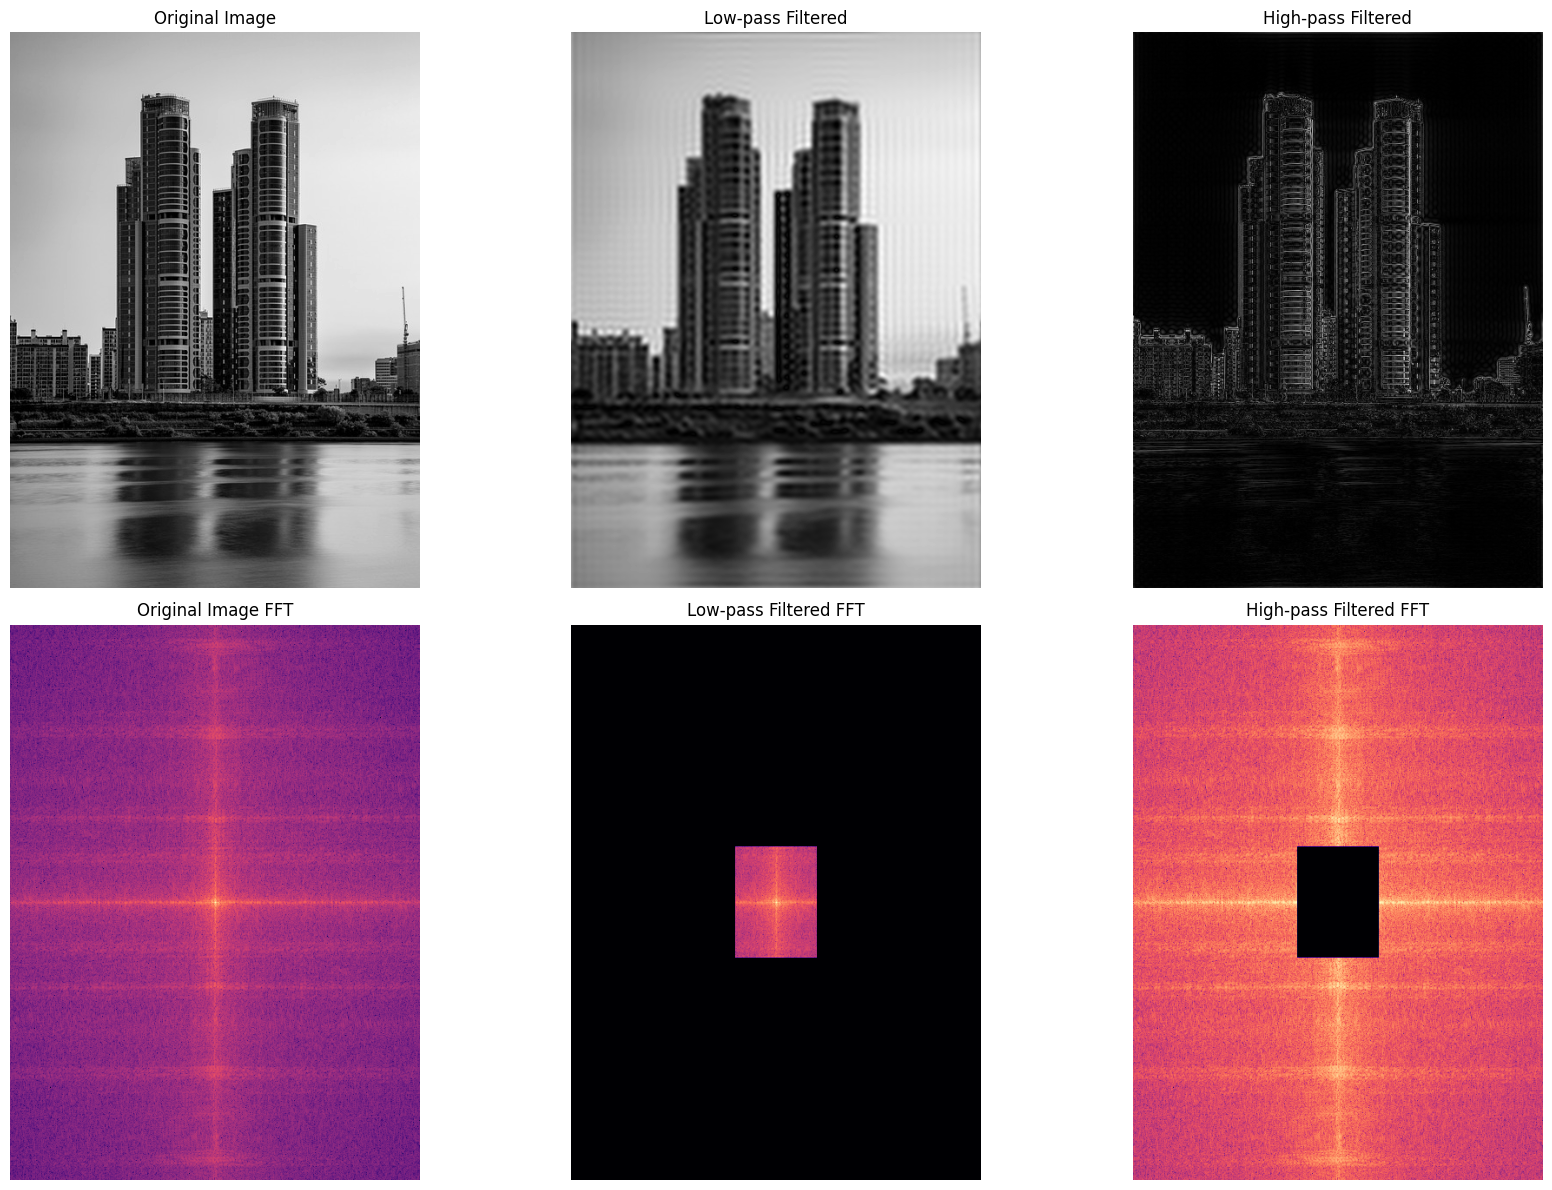

In [3]:
def LPF(fshift, cut=0.1):
    h,w = fshift.shape
    ch,cw = h//2,w//2
    mask = np.zeros((h,w), np.uint8)
    mask[ch-int(cut*h):ch+int(cut*h), cw-int(cut*w):cw+int(cut*w)] = 1
    return fshift * mask

def HPF(fshift, cut=0.1):
    h,w = fshift.shape
    ch,cw = h//2,w//2
    mask = np.ones((h,w), np.uint8)
    mask[ch-int(cut*h):ch+int(cut*h), cw-int(cut*w):cw+int(cut*w)] = 0
    return fshift * mask

# step 1 : FFT 변환 후 shift
freq_shift, freq = FFT(img_gray)

# step 2 : FFT 변환 후 filtering
freq_LPF = LPF(freq_shift.copy(), cut=0.1)
freq_HPF = HPF(freq_shift.copy(), cut=0.1)

# step 3 : IFFT
img_LPF = IFFT(freq_LPF)
img_HPF = IFFT(freq_HPF)

# step 4: 스케일링
fft_lowpass = 20*np.log(np.abs(freq_LPF) + 1)
fft_highpass = 20*np.log(np.abs(freq_HPF) + 1)

fig, ax = plt.subplots(2,3, figsize=(18,12))

titles = ['Original Image', 'Low-pass Filtered', 'High-pass Filtered']
images = [img_gray, img_LPF, img_HPF]
ffts = [freq, fft_lowpass, fft_highpass]

for i in range(3):
    ax[0,i].imshow(images[i], cmap='gray')
    ax[0,i].set_title(titles[i])
    ax[0,i].axis('off')

    ax[1,i].imshow(ffts[i], cmap='magma')
    ax[1,i].set_title(f'{titles[i]} FFT')
    ax[1,i].axis('off')

plt.tight_layout()
plt.show()

* 필터가 등방성이 아니다.

* 직사각형 모양이라 특정 방향에서는 더 필터링되기 때문에, 물결 현상이 발생한다.

* Low Pass의 경우는 Bluring을, High Pass의 경우는 Edge Detection의 역할을 한다.

## **2. Blurring**

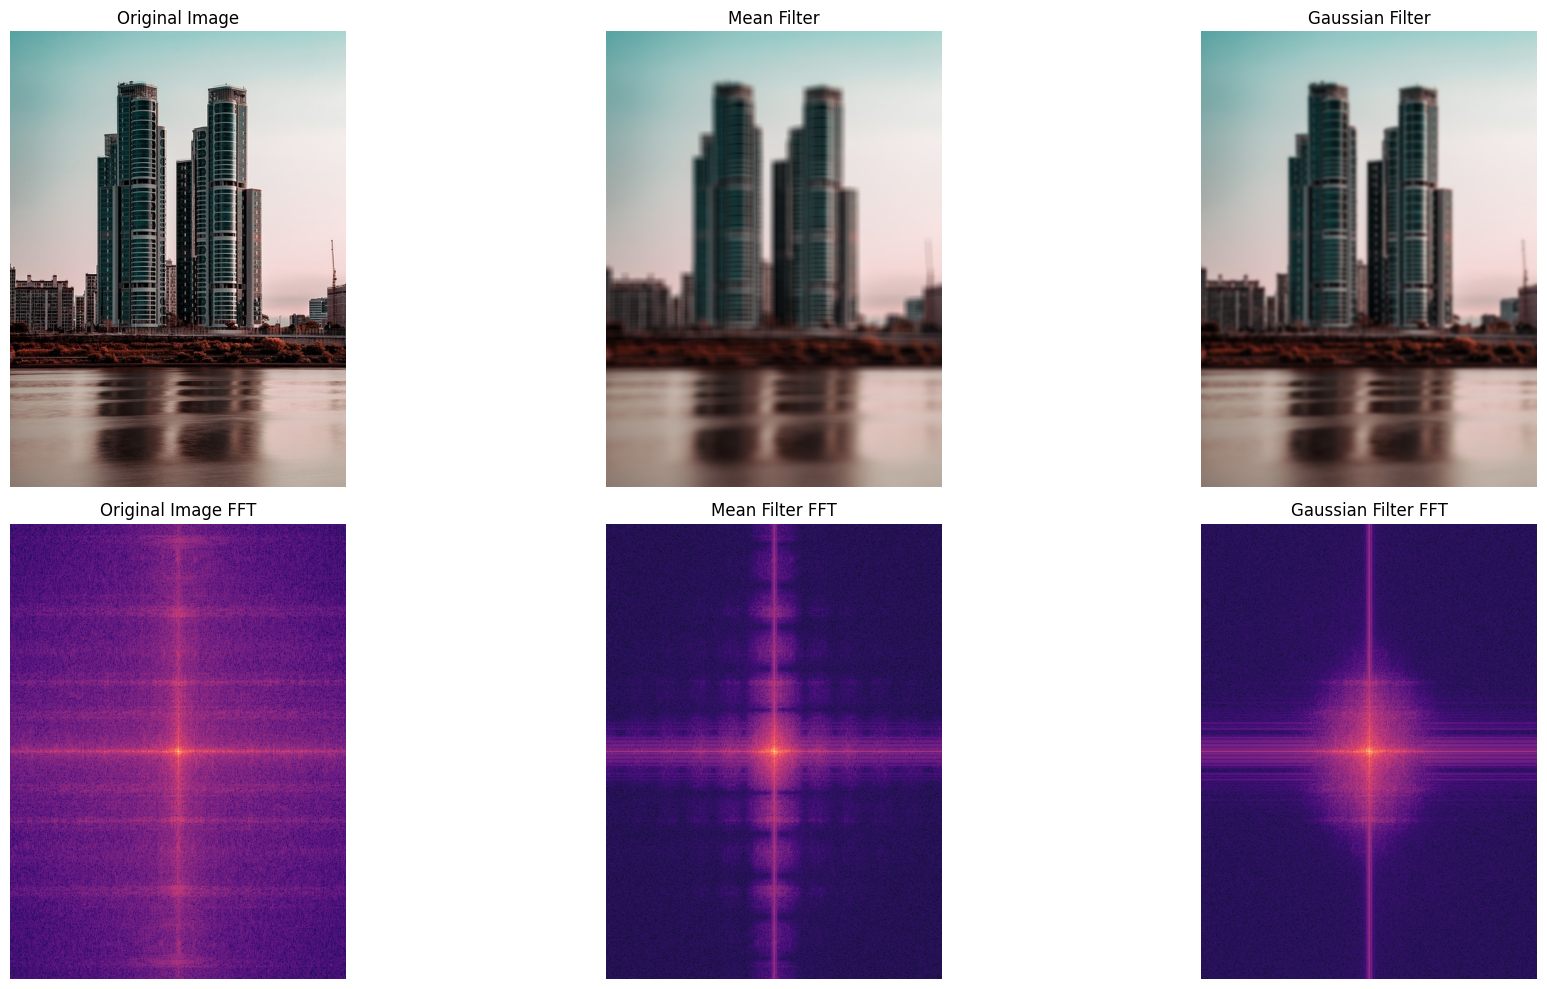

In [4]:
def get_kernel(img, k: int):
    
    mean_kernel = np.ones((k,k), np.float32) / k**2
    mean_filtered = cv2.filter2D(img, -1, mean_kernel)

    gaussian_kernel_x = cv2.getGaussianKernel(k,0)
    gaussian_kernel = gaussian_kernel_x @ gaussian_kernel_x.T
    gaussian_filtered = cv2.filter2D(img, -1, gaussian_kernel)

    return mean_filtered, gaussian_filtered

mean_blur, gaussian_blur = get_kernel(img, 11)

filtered_images = {
    'Original Image': img,
    'Mean Filter': mean_blur,
    'Gaussian Filter': gaussian_blur
}

filtered_ffts = {
    name: np.mean([FFT(image[:,:,i])[1] for i in range(3)], axis=0)
    for name, image in filtered_images.items()
}

fig, ax = plt.subplots(2,3, figsize=(20, 10))

for i, (name, image) in enumerate(filtered_images.items()):
    ax[0,i].imshow(image)
    ax[0,i].set_title(name)
    ax[0,i].axis('off')

for i, (name, magnitude) in enumerate(filtered_ffts.items()):
    ax[1,i].imshow(magnitude, cmap='magma')
    ax[1,i].set_title(f'{name} FFT')
    ax[1,i].axis('off')

plt.tight_layout()
plt.show()

* 원본 이미지에서 블러링을 적용하면 바깥쪽으로 (High pass band) 갈수록 값이 작아지는 것을 확인할 수 있다.

* Mean Filter에서 저주파가 Gaussian Filter보다 더 많이 날아가서 더 흐린 모습을 확인할 수 있다.

## **3. Kernel Viz**
* 커널을 통해서 어떤식으로 필터링 되는지 알아보자.

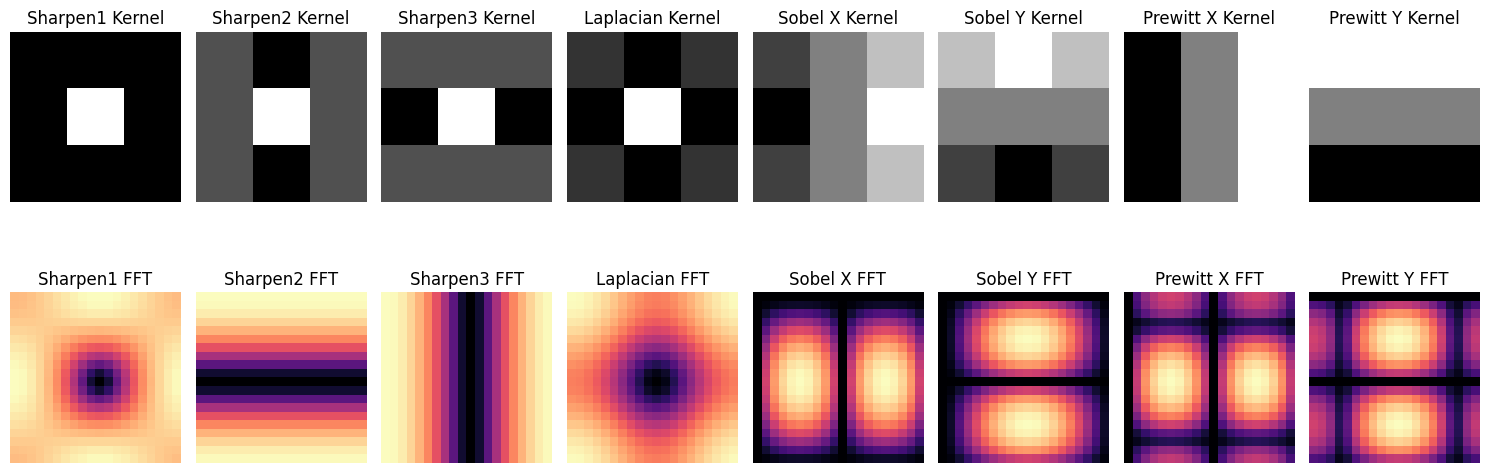

In [5]:
kernels = {
    'Sharpen1': np.array([
        [-2, -2, -2],
        [-2, 17, -2],
        [-2, -2, -2]
    ]),
    'Sharpen2': np.array([
        [0, -5, 0],
        [0, 11, 0],
        [0, -5, 0]
    ]),
    'Sharpen3': np.array([
        [0, 0, 0],
        [-5, 11, -5],
        [0, 0, 0]
    ]),
    'Laplacian': np.array([
        [0, -1, 0],
        [-1, 4, -1],
        [0, -1, 0]
    ]),
    'Sobel X': np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ]),
    'Sobel Y': np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ]),
    'Prewitt X': np.array([
        [-1, 0, 1],
        [-1, 0, 1],
        [-1, 0, 1]
    ]),
    'Prewitt Y': np.array([
        [1, 1, 1],
        [0, 0, 0],
        [-1, -1, -1]
    ])
}

def fft_kernel(kernel):
    padded_kernel = np.pad(kernel, ((0,20-kernel.shape[0]), (0,20-kernel.shape[1])), 'constant')
    f = np.fft.fft2(padded_kernel)
    fshift = np.fft.fftshift(f)
    magnitude = 20 * np.log(np.abs(fshift) + 1)
    return magnitude

fig,ax = plt.subplots(2, len(kernels), figsize=(15, 6))

for i, (name, kernel) in enumerate(kernels.items()):
    ax[0,i].imshow(kernel, cmap='gray')
    ax[0,i].set_title(f'{name} Kernel')
    ax[0,i].axis('off')
    
    kernel_fft = fft_kernel(kernel)
    ax[1,i].imshow(kernel_fft, cmap='magma')
    ax[1,i].set_title(f'{name} FFT')
    ax[1,i].axis('off')

plt.tight_layout()
plt.show()